# Session 4. Modelling spatial networks

Many real-world networks are embedded into geographical space. For example:
- human mobility networks (nodes - locations in space, edge weights - number of people moving between two locations);
- aggregated networks of human interactions (nodes - locations in space, edge weights - cumulative communication flux);
- social networks, when people are attached to their home locations (nodes - people, edge weights - strength of connections between them or simply existance of such connections in the unweighted case).

In this case nodes are given spatial coordinates, while edges, together with their network topology weight $e(a,b)$, can also be assigned their geographical distance $d(a,b)$. We'll refer to such network as "spatial networks".

It is a common property for many spatial networks to have edge weight decay with distance (connections between more distant objects are weaker). This dependence is often thought as a power-law trend:
$$
e(a,b)\sim d(a,b)^{-\gamma}.
$$

However often nodes are not equal - for example in case of human mobility networks, where nodes are locations in space, while edges represent number of people moving between them, nodes might be of different size or different density. In this case one could also consider
$$
e(a,b)\sim w(a),\ e(a,b)\sim w(b),
$$
or more generally (keeping an idea of the power-law dependence and assuming under-/super-linear scaling of destination attractiveness or origin activity with size): 
$$
e(a,b)\sim w(a)^\alpha,\ e(a,b)\sim w(b)^\beta.
$$
where $w(x)$ is the weight of the node $x$. 

## Gravity model

All together those relations lead to a model
$$
e(a,b)=k\cdot w(a) w(b) d(a,b)^{-\gamma},
$$
or more generally
$$
e(a,b)=k\cdot w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma},
$$
where $k$ is the global proportionality (normalization) factor
$$
k=\frac{\sum\limits_{a,b}e(a,b)}{\sum\limits_{a,b} w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma}}.
$$

In case network does not have loop edges to model, the normalization factor is defined as
$$
k=\frac{\sum\limits_{a\neq b}e(a,b)}{\sum\limits_{a\neq b} w(a)^\alpha w(b)^\beta d(a,b)^{-\gamma}}.
$$

Often it is reasonable to assume that $\alpha=\beta$ (especially if the network is symmetric, like representing number of people visiting both locations $a$ and $b$ regardless their order or cumulative communication flux between the two locations regardless directionality). 

This model is called gravity model.

## Gravity model with local normalization

Alternatively, one can also introduce local normalization, assuming relative scaling of strength of attractiveness of different destinations $b$ for the origin $a$ to be proportional to
$$
{\rm attr}_a(b)\sim w(b)^\beta d(a,b)^{-\gamma}.
$$
Given the known total outgoing strength $T(a)$ for each node $a$, this leads to the model
$$
e(a,b)=T(a) \frac{{\rm attr}_a(b)}{\sum_c {\rm attr}_a(c)}
$$
i.e.
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_c w(c)^\beta d(a,c)^{-\gamma}}.
$$
In case loop edges are missing in the network one should rather write
$$
e(a,b)=T(a) \frac{w(b)^\beta d(a,b)^{-\gamma}}{\sum_{c\neq a} w(c)^\beta d(a,c)^{-\gamma}},
$$
as the entire outgoing strenth is to be distributed among the possible non-loop edges for $c\neq a$. 

## Radiation model

Another alternative approach to modelling spatial networks of human mobility and potentially interactions has been suggested in a recent paper [Simini, F., González, M. C., Maritan, A., & Barabási, A. L. (2012). A universal model for mobility and migration patterns. Nature, 484(7392)]. The key idea is that people select a closet destination bettan than the one they have in their location of origin according to a certain attractiveness distribution and the beauty of the model is that it gives a one single paramter-free formulae (just based on the given population distribution, nothing to fit or assume unlike the exponents in the gravity model), no matter what the assumed attractiveness distribution was. The model however also relies on the knowledge of the cumulative outgoing strength of the nodes, just like the gravity model with the local normalization does.

The model predicting mobility flux (an edge) $e(a,b)$ between two locations $a,b$ is
$$
e(a,b)=T(a)\frac{p(a)p(b)}{\left(p(a)+s(a,b)\right)\left(p(a)+p(b)+s(a,b)\right)},
$$
where $p(a)$ denotes the population of the location $a$, while $s(a,b)$ is the total population enclosed in the circle centered in $a$ with the radius equal to $d(a,b)$ (i.e. the total population residing no further from $a$ compared to $b$).

## US State2State migration modeling - gravity law

First of all read the state2state migration data and build a network based on it

In [4]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
from scipy import optimize
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [5]:
# load migration data (edge list of migration fluxes between states number in alphabetic order)
USmigration=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab4/USstates_migration.csv' , header=0 )
USmigration.head()

,i,j,a
0,1,1,588293
1,2,1,93
2,3,1,833
3,4,1,691
4,5,1,2087


In [6]:
# load state total population data (states numbered in the same order)
state_pop=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab4/USstate_pop.csv' , header=0 )
state_pop.head()

,State,Population
0,1,4745278
1,2,711962
2,3,6402301
3,4,2906632
4,5,37222678


In [7]:
# load distances between states (computed based on the shapefiles)
USStates_dist=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab4/USstates_dist.csv' , header=0 )
USStates_dist.head()

,i,j,d
0,2,1,5614.436960
1,3,1,2495.344624
2,4,1,573.987494
3,5,1,3126.573252
4,6,1,1998.429707


In [8]:
#creating a directed weighted graph of US migration adding all the edges
USmig=nx.DiGraph()
nx.set_edge_attributes(USmig,'weight', 0)
for k in USmigration.index:
    USmig.add_edge(USmigration.i[k],USmigration.j[k],weight=USmigration.a[k])

In [9]:
#adding edge distances
nx.set_edge_attributes(USmig,'dist', 0)
for k in USStates_dist.index:
    if not USmig.has_edge(USStates_dist.i[k],USStates_dist.j[k]):
        USmig.add_edge(USStates_dist.i[k],USStates_dist.j[k],weight=0)
    USmig[USStates_dist.i[k]][USStates_dist.j[k]]['dist']=USStates_dist.d[k]

Now try to establish overall dependence of the edge weight on the distance

In [10]:
#create a dataframe with edge distances and weights
data=pd.DataFrame({'d':[],'e':[]})
for e in USmig.edges(data=True):
    i=data.index.max()
    if isnan(i):
        i=-1
    data.loc[i + 1] = [e[2]['dist'], e[2]['weight']]

In [11]:
#take only edges with positive distances and weights (do not consider empty and loop edges)
data=data.loc[(data.d>=1)&(data.e>0)]
data.head()

,d,e
1,5614.436960,1771
2,2495.344624,1677
3,573.987494,1642
4,3126.573252,3389
5,1998.429707,348


                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     284.8
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           1.89e-60
Time:                        13:48:46   Log-Likelihood:                -4440.5
No. Observations:                2383   AIC:                             8885.
Df Residuals:                    2381   BIC:                             8897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     11.8443      0.298     39.697      0.0

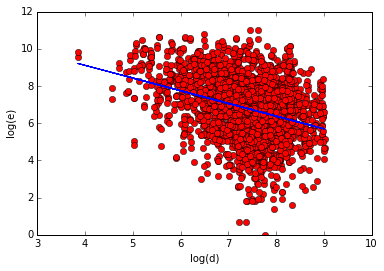

In [12]:
#fit a power law e~d^q on a log-scale and visualize the dependence
lm = smf.ols(formula='log(e) ~ log(d)', data = data).fit()
print(lm.summary())
lme = lm.predict(data)
plt.plot(log(data.d),log(data.e),'or')
plt.plot(log(data.d),lme,'-b')  
plt.xlabel('log(d)')
plt.ylabel('log(e)')

now try the standard gravity law

In [13]:
#assign weights to the nodes based on their population
USmig_w={}
for k in state_pop.index:
    USmig_w[state_pop.State[k]]=state_pop.Population[k]

In [14]:
#remove loop edges (in-state migrations)
for k in USmig.nodes():
    USmig[k][k]['weight']=0

In [15]:
USmig_wout=USmig.out_degree(weight='weight')
USmig_win=USmig.in_degree(weight='weight')

In [16]:
data=pd.DataFrame({'d':[],'e':[],'w1':[],'w2':[]})
for e in USmig.edges(data=True):
    i=data.index.max()
    if isnan(i):
        i=-1
    data.loc[i + 1] = [e[2]['dist'], e[2]['weight'], USmig_w[e[0]], USmig_w[e[1]]]

In [17]:
USmig[1][1]

{'dist': 0, 'weight': 0}

In [18]:
data1=data.loc[(data.d>1)&(data.e>0)&(data.w1>0)&(data.w2>0)]
data1.head()

,d,e,w1,w2
1,5614.436960,1771,4745278,711962
2,2495.344624,1677,4745278,6402301
3,573.987494,1642,4745278,2906632
4,3126.573252,3389,4745278,37222678
5,1998.429707,348,4745278,5048443


                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     921.5
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        13:48:53   Log-Likelihood:                -3656.4
No. Observations:                2383   AIC:                             7321.
Df Residuals:                    2379   BIC:                             7344.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -12.5761      0.562    -22.377      0.0

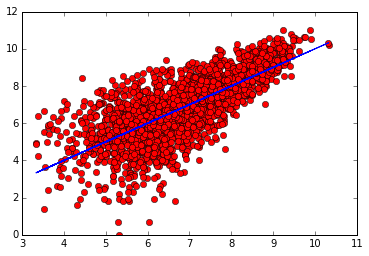

In [19]:
lm = smf.ols(formula='log(e) ~ log(d)+log(w1)+log(w2)', data = data1).fit()
print(lm.summary())
lme = lm.predict(data1)
plt.plot(lme,log(data1.e),'or')
plt.plot(lme,lme,'-b')  

now perform model validation fitting it on one part of the network and applying to the other

In [20]:
#now perform model validation
random.seed(2015)
ind=stat.bernoulli.rvs(p = 0.67, size = len(data1.e))
train=data1.loc[ind==1]
valid=data1.loc[ind==0]

                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     589.9
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          1.50e-256
Time:                        13:48:54   Log-Likelihood:                -2431.3
No. Observations:                1571   AIC:                             4871.
Df Residuals:                    1567   BIC:                             4892.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -12.9251      0.693    -18.641      0.0

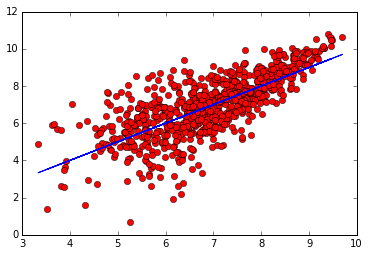

In [21]:
lm = smf.ols(formula='log(e) ~ log(d)+log(w1)+log(w2)', data = train).fit()
print(lm.summary())
lme = lm.predict(valid)
plt.plot(lme,log(valid.e),'or')
plt.plot(lme,lme,'-b')
R2=1-sum(pow(log(valid.e)-lme,2))/sum(pow(log(valid.e)-mean(log(valid.e)),2)) 
print('Validation error={0}'.format(R2))

## US State2State migration modeling - gravity law with local normalization

In [22]:
# function locally normalized gravity model fit (in terms of log-scale R2) for given exponents q
def LNGmodel(q):
    #first pass - assign relative weights as the model prediction
    for e in USmig.edges():
        if e[0]!=e[1]:
            USmig[e[0]][e[1]]['predict']=(USmig[e[0]][e[1]]['dist']**q[0])*(USmig_w[e[1]]**q[1])
        else:
            USmig[e[0]][e[1]]['predict']=USmig[e[0]][e[1]]['weight']
            
    #compute normalization factors    
    USmig_norm=USmig.out_degree(weight='predict')
    for a in USmig.nodes():
        USmig_norm[a]=(USmig_wout[a]-USmig[a][a]['weight'])/(USmig_norm[a]-USmig[a][a]['predict'])
    #second pass - normalize model predictions   
    E=np.array([0.0]*USmig.size())
    me=np.array([0.0]*USmig.size())
    i=0
    for e in USmig.edges():
        if e[0]!=e[1]:
            USmig[e[0]][e[1]]['predict']*=USmig_norm[e[0]]
            #print(USmig[e[0]][e[1]]['weight'],USmig[e[0]][e[1]]['predict'])
            E[i]=USmig[e[0]][e[1]]['weight']
            me[i]=USmig[e[0]][e[1]]['predict']
            i+=1
    E=E[0:i]
    me=me[0:i]
    me=me[E>0]
    E=E[E>0]
    R2=1-sum(pow(log(E)-log(me),2))/sum(pow(log(E)-mean(log(E)),2))    
    return (R2,E,me) #performance and edge weights-predictions for fit visualization purposes 

In [23]:
def LNGmodelFit(q):
    #version for maximization
    return -LNGmodel(q)[0]

In [24]:
#fit model parameters
res=optimize.minimize(LNGmodelFit,[0, 1],method='Nelder-Mead')

In [25]:
res

  status: 0
    nfev: 101
 success: True
     fun: -0.56986182165014876
       x: array([-0.97896782,  0.90916446])
 message: 'Optimization terminated successfully.'
     nit: 52

In [26]:
(R2,e,me)=LNGmodel(res.x)

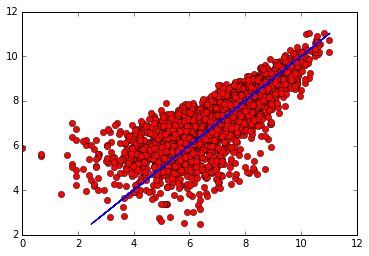

In [27]:
plt.plot(log(e),log(me),'or')
plt.plot(log(me),log(me),'-b')  

R2 on real scale
train - validation

## Taxi ridership

In [28]:
taxioct = pd.read_csv('https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab2/oct2013aggr2.csv',header=-1)

In [29]:
NYCCD_dist=pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/NetworkAnalysis/lab4/NYCCD_dist.csv' , header=0 )

In [30]:
taxioct.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,7319,311,311,0,0,0.00,0,0,0.00,0.0000,0.0,0.0000,0.00,0.0000
1,7319,312,311,0,0,0.00,0,0,0.00,0.0000,0.0,0.0000,0.00,0.0000
2,7319,480,311,2,1900,113.14,1,0,19.57,2.3052,8.2,4.5255,61.45,9.8288
3,7319,501,311,0,0,0.00,0,0,0.00,0.0000,0.0,0.0000,0.00,0.0000
4,7319,205,311,0,0,0.00,0,0,0.00,0.0000,0.0,0.0000,0.00,0.0000


In [31]:
NYCCD_dist.head()

,Var1,Var2,d
0,312,311,13006.427480
1,480,311,74389.349494
2,501,311,43476.068667
3,205,311,95385.229688
4,202,311,81443.894281


In [32]:
#aggregate the network for entire month
taxinet=nx.DiGraph()
for i in taxioct.index:
    if not taxinet.has_edge(taxioct[1][i],taxioct[2][i]):
        taxinet.add_edge(taxioct[1][i],taxioct[2][i],weight=taxioct[3][i])
    else:
        taxinet[taxioct[1][i]][taxioct[2][i]]['weight']+=taxioct[3][i]

In [33]:
minH=min(taxioct[0])
maxH=max(taxioct[0])
taxihn={}
#initialize empty networks for each hour
for h in range(0,maxH-minH+1):
    taxihn[h]=nx.DiGraph()
#aggregate networks per hour    
for i in taxioct.index:
    h=taxioct[0][i]-minH
    if not taxihn[h].has_edge(taxioct[1][i],taxioct[2][i]):
        taxihn[h].add_edge(taxioct[1][i],taxioct[2][i],weight=taxioct[3][i])
    else:
        taxihn[h][taxioct[1][i]][taxioct[2][i]]['weight']+=taxioct[3][i]

In [34]:
for k in NYCCD_dist.index:
    if taxinet.has_edge(NYCCD_dist.Var1[k],NYCCD_dist.Var2[k]):
        taxinet[NYCCD_dist.Var1[k]][NYCCD_dist.Var2[k]]['dist']=NYCCD_dist.d[k]
    for h in range(0,maxH-minH+1):    
        if taxihn[h].has_edge(NYCCD_dist.Var1[k],NYCCD_dist.Var2[k]):
            taxihn[h][NYCCD_dist.Var1[k]][NYCCD_dist.Var2[k]]['dist']=NYCCD_dist.d[k]        

Fit gravity model to the entire month taxi data (node weights taken from the network with distinguishing between incoming and outgoing weights)

In [35]:
#first summarize the above approach into a reusable function
def fitGravity(net,w_out,w_in,vis):
    data=pd.DataFrame({'d':[],'e':[]})
    for e in net.edges(data=True):
        i=data.index.max()
        if isnan(i):
            i=-1
        if (e[0]!=e[1])&(e[0]>0)&(e[1]>0)&(w_out[e[0]]>0)&(w_in[e[1]]>0):
            data.loc[i + 1] = [e[2]['dist'], 1.0*e[2]['weight']/w_out[e[0]]/w_in[e[1]]]
    data=data.loc[(data.d>=1)&(data.e>0)]        
    lm = smf.ols(formula='log(e) ~ log(d)', data = data).fit()
    if vis:
        print(lm.summary())
        lme = lm.predict(data)
        plt.plot(log(data.d),log(data.e),'or')
        plt.plot(log(data.d),lme,'-b')     
    return lm.params[1]    

In [36]:
tw_out=taxinet.out_degree(weight='weight')
tw_in=taxinet.in_degree(weight='weight')

                            OLS Regression Results                            
Dep. Variable:                 log(e)   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     1361.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          2.61e-247
Time:                        14:04:49   Log-Likelihood:                -5754.0
No. Observations:                3098   AIC:                         1.151e+04
Df Residuals:                    3096   BIC:                         1.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.3742      0.474      2.897      0.0

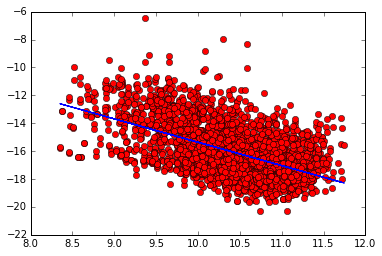

In [37]:
par=fitGravity(taxinet,tw_out,tw_in,True)

In [ ]:
par

-1.6738318200995543

In [ ]:
p=[0]*(maxH-minH+1)
for h in range(0,maxH-minH+1):
   p[h]=fitGravity(taxihn[h],tw_out,tw_in,False)
   print('Hour {0}:{1}'.format(h,p[h]))

Hour 0:-0.282222679091
Hour 1:-0.325979621599
Hour 2:-0.122509168168
Hour 3:-0.0485869549664
Hour 4:0.0551075919894
Hour 5:0.552385536322

In [ ]:
plt.figure(figsize = (18,6))
plt.plot(p,':')